In [98]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.interactiveshell import InteractiveShell
# display value of cell-final assignment statement as well as expression 
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Interactive Data Visualisation with Python

## Jupyter Notebooks

Interactive development environment (IDE) that's great for data analysis.

A Jupyter Notebook is a sequence of _cells_ that are of two main types:
1. **Text cells** (using Markdown)
2. **Code cells** (Python for us)

Cells are run, and produce visual outputs:
* Standard output produced by Python 
* Tabular data
* Visualisations


## The Dataset

The Melbourne City Council's Pedestrian Counting System datasets.

_This dataset contains hourly pedestrian counts since 2009 from pedestrian sensor devices located across the city. The data is updated on a monthly basis and can be used to determine variations in pedestrian activity throughout the day._

Two separate datasets:

1. [The Pedestrian Counting System dataset](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-2009-to-Present-counts-/b2ak-trbp), which contains the hourly traffic data.
2. [Pedestrian Sensor Locations](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234) dataset, which contains data about the sensors collecting the above data. 

In [1]:
import os
from pathlib import Path

data_path = Path(os.getenv("DATA_PATH", "../data"))
sensor_csv_path = data_path / "Pedestrian_Counting_System_-_Sensor_Locations.csv"
counts_csv_path = data_path / "Pedestrian_Counting_System___2009_to_Present__counts_per_hour_.csv"

## Outcomes

What questions are we trying to answer?

1. _What does monthly traffic look like over the years?_
2. _What are the most trafficked parts of Melbourne’s CBD?_
4. _What does daily traffic look like?_

### A Crash Course in Pandas

Pandas is a Python tool for general purpose data manipulation and analysis.

Kind of like Excel + SQL for Python... but so much more!

Two main data types:
* `DataFrame`
* `Series`


Let's load the dataset of hourly pedestrian counts:

In [99]:
import pandas as pd

counts_df = pd.read_csv(counts_csv_path, index_col="ID", parse_dates=["Date_Time"]);

In [22]:
type(counts_df)

pandas.core.frame.DataFrame

In [6]:
counts_df.head()

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
0,2887628,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,36,Queen St (West),774


Think of `DataFrame`s are a 2-dimensional data structure: **rows** x **columns**

In [4]:
counts_df.shape

(3347338, 9)

In [3]:
counts_df.dtypes

Date_Time        datetime64[ns]
Year                      int64
Month                    object
Mdate                     int64
Day                      object
Time                      int64
Sensor_ID                 int64
Sensor_Name              object
Hourly_Counts             int64
dtype: object

Each column of a `DataFrame` is a `Series`.

A `Series` is a 1-dimensional data structure.

Like a Python list, but:
* has a type
* has an index

In [5]:
counts_df["Hourly_Counts"]

ID
2887628    300
2887629    604
2887630    216
2887631    627
2887632    774
          ... 
3347334     11
3347335     27
3347336      0
3347337      0
3347338      0
Name: Hourly_Counts, Length: 3347338, dtype: int64

In [93]:
# filtering the dataframe to Southbank Sensor records

southbank_df = counts_df[counts_df["Sensor_Name"] == "Southbank"]

,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
ID,,,,,,,,,
2887637,2019-11-01 17:00:00,2019,November,1,Friday,17,35,Southbank,2691
2887692,2019-11-01 18:00:00,2019,November,1,Friday,18,35,Southbank,2292
2887747,2019-11-01 19:00:00,2019,November,1,Friday,19,35,Southbank,2058
2887802,2019-11-01 20:00:00,2019,November,1,Friday,20,35,Southbank,1695
2887857,2019-11-01 21:00:00,2019,November,1,Friday,21,35,Southbank,1825
...,...,...,...,...,...,...,...,...,...
3347076,2020-09-30 19:00:00,2020,September,30,Wednesday,19,35,Southbank,217
3347136,2020-09-30 20:00:00,2020,September,30,Wednesday,20,35,Southbank,82
3347196,2020-09-30 21:00:00,2020,September,30,Wednesday,21,35,Southbank,59


In [24]:
# filtering further to only saturday 

southbank_sat_df = southbank_df[southbank_df["Day"] == "Saturday"]

In [34]:
# Total pedestrians through Southbank on Saturday

southbank_sat_df["Hourly_Counts"].sum()

8586703

In [35]:
# Mean pedestrians through Southbank on Saturday

southbank_mon_df["Hourly_Counts"].mean()

1314.2539682539682

In [38]:
# vectorised arithmetic

southbank_sat_df["Hourly_Counts"] + 1

ID
2888022    422
2888077    305
2888132     96
2888187     37
2888242     23
          ... 
3341211    185
3341273    112
3341335     17
3341397     13
3341459     10
Name: Hourly_Counts, Length: 5568, dtype: int64

**Key points:**

When working with Pandas, you are manipulating `DataFrame` objects and their columns, which are `Series` objects.

Try to use vectorised operations over these data structures rather than `for` loops.

## Exploratory Data Analysis (EDA)

Dive into your data and get your hands dirty in order to:
* Identify data quality or integrity issues
* Understand applications the data supports (and does not support!)

Involves: 
* Extracting summary stastistics of the data
* Visualising your data

### Let's do some exploratory analysis on records from 2019

In [100]:
# filter down to 2019

counts_2019_df = counts_df[counts_df["Year"] == 2019]

,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
ID,,,,,,,,,
2887628,2019-11-01 17:00:00,2019,November,1,Friday,17,34,Flinders St-Spark La,300
2887629,2019-11-01 17:00:00,2019,November,1,Friday,17,39,Alfred Place,604
2887630,2019-11-01 17:00:00,2019,November,1,Friday,17,37,Lygon St (East),216
2887631,2019-11-01 17:00:00,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
2887632,2019-11-01 17:00:00,2019,November,1,Friday,17,36,Queen St (West),774
...,...,...,...,...,...,...,...,...,...
2886659,2019-10-31 23:00:00,2019,October,31,Thursday,23,57,Bourke St Bridge,73
2886660,2019-10-31 23:00:00,2019,October,31,Thursday,23,58,Bourke St - Spencer St (North),312
2886661,2019-10-31 23:00:00,2019,October,31,Thursday,23,59,Swanston St - RMIT Building 80,3


In [95]:
# group by Month

months_2019 = counts_df.groupby("Month")["Hourly_Counts"].sum()

Month
April        151564562
August       156924169
December     170223773
February     156843588
January      157435313
July         160708146
June         149554005
March        172436211
May          156137355
November     160487798
October      161901572
September    157093637
Name: Hourly_Counts, dtype: int64

In [43]:
# get various summary statistics

months_2019.describe()

count    1.200000e+01
mean     1.592758e+08
std      6.653032e+06
min      1.495540e+08
25%      1.566670e+08
50%      1.572645e+08
75%      1.610065e+08
max      1.724362e+08
Name: Hourly_Counts, dtype: float64

In [51]:
# idxmax and idxmin are like max and min but return indexes

print(f"Busiest month is: {months_2019.idxmax()}")
print(f"Least busy month is: {months_2019.idxmin()}")

Busiest month is: March
Least busy month is: June


### Visual Exploration with Plotly

In [55]:
months_2019

Month
April        151564562
August       156924169
December     170223773
February     156843588
January      157435313
July         160708146
June         149554005
March        172436211
May          156137355
November     160487798
October      161901572
September    157093637
Name: Hourly_Counts, dtype: int64

In [79]:
# turn the series into a DataFrame

months_2019_df = months_2019.reset_index()

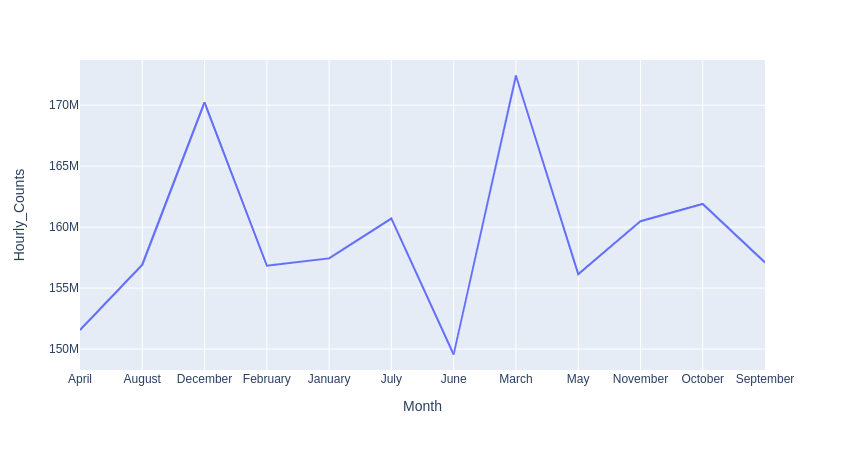

In [70]:
import plotly.express as px

px.line(months_2019_df, x="Month", y="Hourly_Counts")

Problems:
1. It's alphabetically sorted
2. Data points aren't easily identifable
3. Plot is not well documented

Let's fix these!

In [102]:
# sort by month numbers
from datetime import datetime

sorted_months_2019_df = months_2019_df.sort_values(
    by="Month", 
    key=lambda x:pd.to_datetime(x, format="%B").dt.month
)

,Month,Hourly_Counts
4,January,157435313
3,February,156843588
7,March,172436211
0,April,151564562
8,May,156137355
6,June,149554005
5,July,160708146
1,August,156924169
11,September,157093637
10,October,161901572


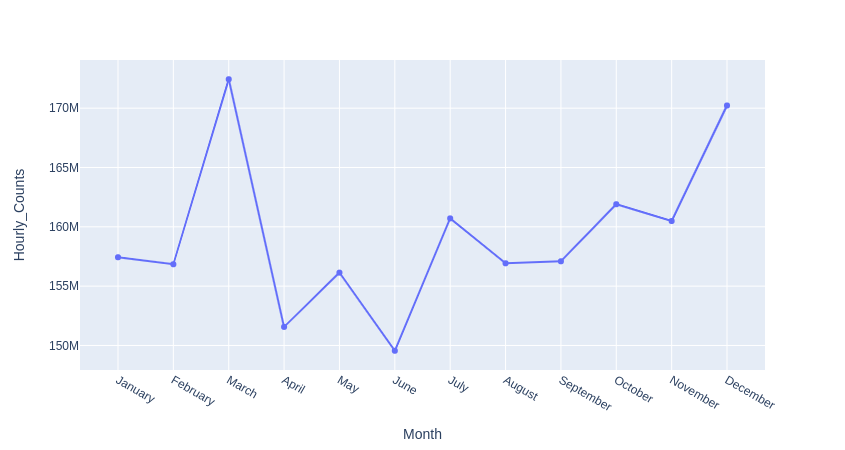

In [106]:
# add markers to data points

figure = px.line(sorted_months_2019_df, x="Month", y="Hourly_Counts")
figure.update_traces(mode='lines+markers')

#### __*Hot Tip:*__ Always title your plots!

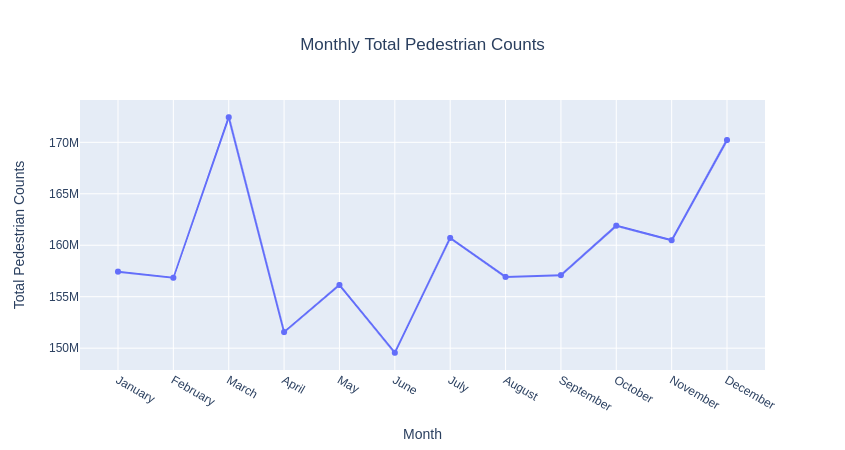

In [113]:
# Improve accessability of the plot with title and better y-axis label

figure = px.line(
    sorted_months_2019_df, 
    x="Month", 
    y="Hourly_Counts", 
    title="Monthly Total Pedestrian Counts"
)
figure.update_traces(mode='lines+markers')
figure.update_layout(yaxis_title="Total Pedestrian Counts", title_x=0.5)

## Q1: _What does monthly traffic look like over the years?_

TODO:

* first version: the plot from EDA but wrapped up in a function
* highlight the three step process of: wrangle, plot, fine-tune
* make into interactive interface using ipywidgets (and using filter_df?)

In [133]:
# second version by sensors with bar charts
def plot_month_counts(df, split_sensors=False, **kwargs):
    """Make a bar plot of monthly counts"""
    if split_sensors:
        group_cols = ["Month", "Sensor_Name"]
        color = "Sensor_Name"
    else:
        group_cols = ["Month"]
        color = None

    month_df = (
        df.groupby(group_cols)["Hourly_Counts"]
        .sum()
        .reset_index()
        .sort_values(by="Month", key=lambda x: pd.to_datetime(x, format="%B").dt.month)
    )

    figure = px.bar(
        month_df,
        x="Month",
        y="Hourly_Counts",
        barmode="group",
        color=color,
        title="Monthly Sensor Traffic",
        **kwargs,
    )

    figure.update_layout(
        title_x=0.5,
        yaxis_title="Total Counts",
        yaxis_showgrid=False,
        yaxis_zeroline=False,
        xaxis_title=None,
        legend=dict(
            title_text="",
            orientation="h",
            yanchor="bottom",
            y=-0.6,
            xanchor="right",
            x=1,
        ),
    )
    return figure

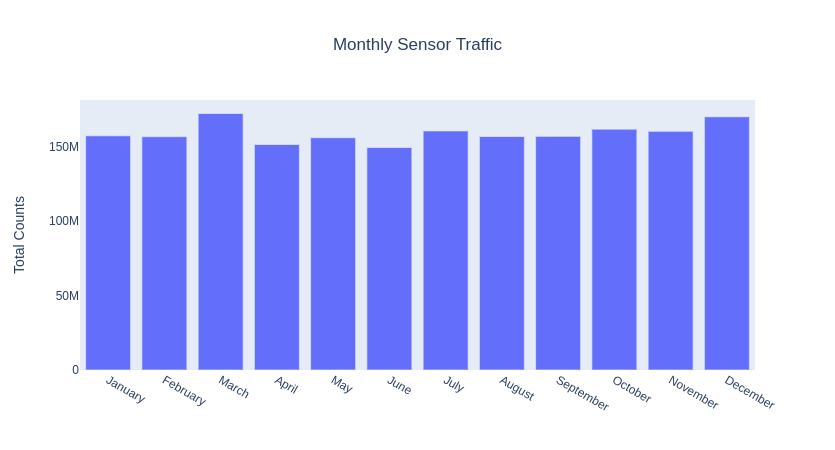

In [134]:
plot_month_counts(months_2019_df)

## Q2: _What are the most trafficked parts of Melbourne’s CBD?_

In [124]:
from melbviz.config import MAPBOX_KEY

px.set_mapbox_access_token(MAPBOX_KEY)


def plot_sensor_map(df, **kwargs):
    """Plot a spatial scatter plot of sensor traffic."""
    sensor_totals_df = (
        df.groupby("Sensor_Name")
        .agg(
            {
                "Hourly_Counts": sum,
                "latitude": lambda x: x.iloc[0],
                "longitude": lambda x: x.iloc[0],
            }
        )
        .reset_index()
        .rename(columns={"Hourly_Counts": "Total Counts"})
    )

    figure = px.scatter_mapbox(
        sensor_totals_df,
        lat="latitude",
        lon="longitude",
        color="Total Counts",
        size="Total Counts",
        text="Sensor_Name",
        color_continuous_scale=px.colors.sequential.Plasma,
        size_max=50,
        zoom=13,
        title="Sensor Traffic",
        **kwargs,
    )

    figure.update_layout(title_x=0.5)
    return figure

## Q3: _What does daily traffic look like?_

In [135]:
def plot_sensor_traffic(
    df,
    same_yscale=False,
    row_height=150,
    limit=5,
    **kwargs,
):
    """Plot hourly traffic for one or more sensors"""
    target_sensors = (
        df.groupby("Sensor_Name")["Hourly_Counts"].sum().sort_values(ascending=False)
    )[:limit]
    df = df[df["Sensor_Name"].isin(set(target_sensors.index))]

    if "height" not in kwargs:
        kwargs["height"] = max(len(target_sensors) * row_height, 400)
    figure = px.line(
        df,
        y="Hourly_Counts",
        x="Date_Time",
        facet_row="Sensor_Name",
        title="Hourly Pedestrian Traffic by Sensor",
        category_orders={"Sensor_Name": list(target_sensors.index)},
        **kwargs,
    )
    
    figure.update_layout(title_x=0.5)
    figure.update_yaxes(
        matches=None if same_yscale else "y",
        showgrid=False,
        zeroline=False,
        title_text=None,
    )
    figure.update_xaxes(showgrid=True, title_text=None)
    figure.for_each_annotation(
        lambda a: a.update(textangle=0, text=a.text.split("=")[-1])
    )
    return figure

### How do we share our interfaces?

#### Option 1: Voila + ngrok

#### Option 2: Dash + ngrok

In [ ]:
# load the sensors datasets

sensors_df = pd.read_csv(sensor_csv_path, index_col="sensor_id")

In [5]:
sensors_df.head()

,sensor_id,sensor_description,sensor_name,installation_date,status,note,direction_1,direction_2,latitude,longitude,location
0,59,Building 80 RMIT,RMIT_T,2019/02/13,A,NaN,North,South,-37.808256,144.963049,"(-37.80825648, 144.96304859)"
1,23,Spencer St-Collins St (South),Col623_T,2013/09/02,A,NaN,East,West,-37.819093,144.954527,"(-37.81909256, 144.95452749)"
2,20,Chinatown-Lt Bourke St (South),LtB170_T,2013/09/06,A,NaN,East,West,-37.811729,144.968247,"(-37.81172913, 144.9682466)"
3,34,Flinders St-Spark La,Fli32_T,2014/06/08,A,NaN,East,West,-37.815380,144.974150,"(-37.81537985, 144.9741505)"
4,57,Bourke St Bridge,BouBri_T,2018/08/13,A,NaN,West,East,-37.817673,144.950256,"(-37.8176735, 144.95025595)"


## Getting Started

Best way to get started is with the Anaconda Python distribution.

<img src="img/anaconda_logo.jpg" width="400"/>

https://www.anaconda.com